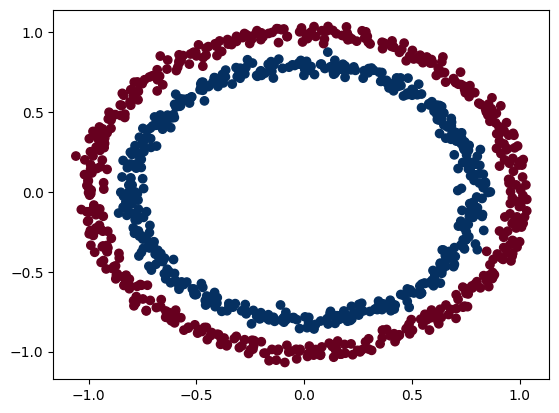

In [1]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [2]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [3]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Replicate CircleModelV0 with nn.Sequential
from torch import nn
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=2),
    nn.ReLU(),
    nn.Linear(in_features=2, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=1, bias=True)
)

In [5]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.1)

In [6]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [7]:
# Fit the model
torch.manual_seed(42)
epochs = 1001

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []
epoch_count = []
    
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train.type(torch.float)) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    train_loss_values.append(loss.detach().numpy())
    train_acc_values.append(acc)
        
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test.type(torch.float))
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
      epoch_count.append(epoch)
      test_acc_values.append(test_acc)
      test_loss_values.append(test_loss.detach().numpy())
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69203, Accuracy: 50.00% | Test Loss: 0.69565, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.00600, Accuracy: 100.00% | Test Loss: 0.01763, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.00227, Accuracy: 100.00% | Test Loss: 0.00978, Test Accuracy: 100.00%
Epoch: 300 | Loss: 0.00125, Accuracy: 100.00% | Test Loss: 0.00640, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.00080, Accuracy: 100.00% | Test Loss: 0.00498, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.00056, Accuracy: 100.00% | Test Loss: 0.00418, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.00042, Accuracy: 100.00% | Test Loss: 0.00373, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.00032, Accuracy: 100.00% | Test Loss: 0.00335, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.00026, Accuracy: 100.00% | Test Loss: 0.00307, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.00021, Accuracy: 100.00% | Test Loss: 0.00285, Test Accuracy: 100.00%
Epoch: 1000 | Loss: 0.00017, Accuracy: 100.00% | Test Loss: 0.00266, Test Accuracy: 100.00%


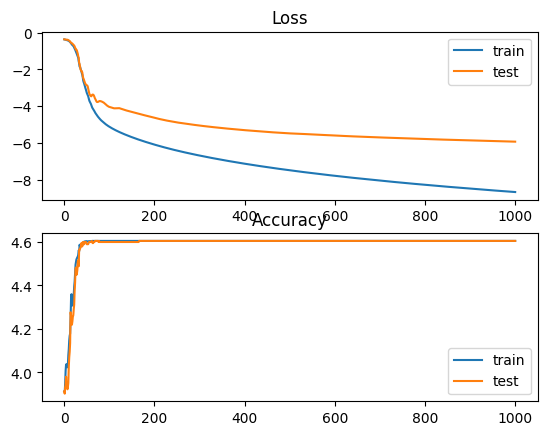

In [8]:
import numpy as np
# plot loss during training and testing
plt.subplot(211)
plt.title('Loss')
plt.plot(epoch_count, np.log(train_loss_values), label='train')
plt.plot(epoch_count, np.log(test_loss_values), label='test')
plt.legend()
# plot accuracy during training and testing
plt.subplot(212)
plt.title('Accuracy')
plt.plot(epoch_count, np.log(train_acc_values), label='train')
plt.plot(epoch_count, np.log(test_acc_values), label='test')
plt.legend()
plt.show()

In [9]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
   
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

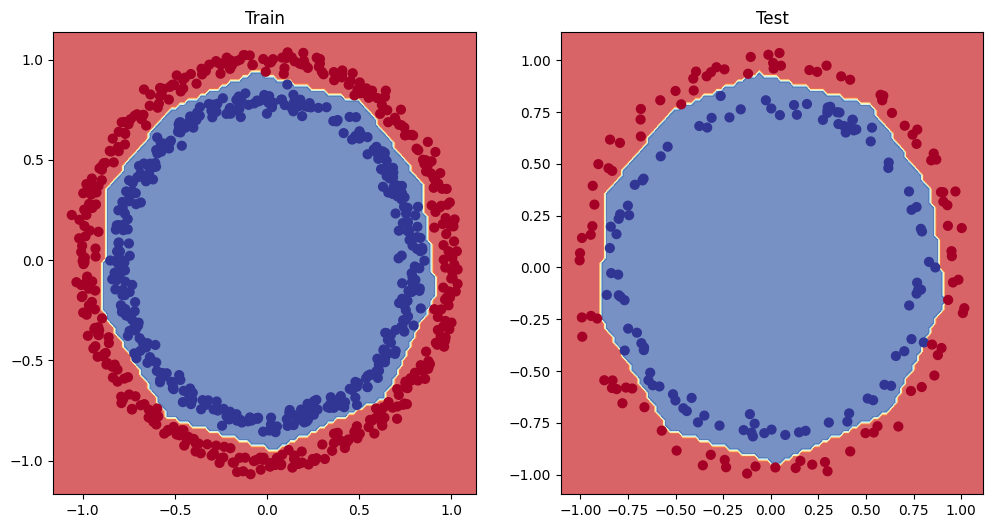

In [10]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) 